In [1]:
import sys
sys.path.append('../')
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import time

from torch.utils.data import DataLoader
from Code.Networks import OuterWrapper


In [2]:
BATCH_SIZE = 1024

USE_JIT = False

device = torch.device('cuda')

In [3]:
test = MNIST('../', transform=transforms.ToTensor(), train=False)

In [4]:

test_loader = DataLoader(test, batch_size=BATCH_SIZE, drop_last=False, num_workers=0)



In [5]:
trigger_signal = torch.ones([783+56, 1, 1], device=device)
trigger_signal[:783] = 0
def encode_input(curr, last):
    out = torch.zeros([783+56, curr.shape[1], 2,40], device=curr.device)
    out[:783, :, 0, :] = ((torch.arange(40, device=curr.device) < 40 * last) & (torch.arange(40, device=curr.device) > 40 * curr)).float()
    out[:783, :, 1, :] = ((torch.arange(40, device=curr.device) > 40 * last) & (torch.arange(40, device=curr.device) < 40 * curr)).float()
    out = torch.cat((out.view([783+56, curr.shape[1], 80]), trigger_signal.expand([783+56, curr.shape[1], 1])), dim=-1)
    return out

In [8]:
id = 'config1'
#n_models = 16

In [9]:
with torch.no_grad():
    model = OuterWrapper(torch.load('../models/'+id), device, USE_JIT)
    confusion = torch.zeros([10,10])
    i = 0
    acc = 0
    for inp, target in test_loader:
        x = inp.view(inp.shape[0], -1, 1).transpose(0,1).to(device)
        x = encode_input(x[1:], x[:-1])
        target = target.to(device)
        outputs, _ = model(x)
        choice = torch.argmax(outputs, 1)
        acc += (choice == target).float().mean()
        i += 1
        for k in range(len(target)):
            confusion[choice[k], target[k]] += 1
    print('Acc: '+str(acc/i))
#print(confusion)

Acc: tensor(0.9051, device='cuda:0')


In [7]:
max = confusion.max().item()
from PIL import Image
img = Image.new('L',(10,10),color=128)
for i in range(10):
    for k in range(10):
        img.putpixel((i, k), int(confusion[i,k]/max*255))

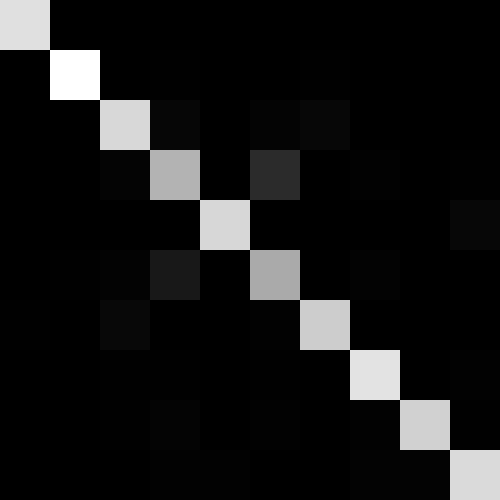

In [8]:
img.resize((500, 500))

In [9]:
testi = MNIST('../../', train=False)

In [ ]:
show = []
schoice = []
starget = []
for img, target in testi:
    x = transforms.ToTensor()(img).view(-1, 1, 1).to(device)
    mem, _ = mem_model(x)
    outputs, _ = post_model(mem[-1].expand(56, 1, 256))
    choice = torch.argmax(outputs.mean(dim=0), 1).item()
    if choice != target:
        show.append(img)
        schoice.append(choice)
        starget.append(target)
        if len(show) == 10:
            break


In [ ]:
show[7].resize((500,500))


In [ ]:
print(schoice)
print(starget)

In [ ]:
mem_model.model.model.layers.shortterm_synapse.named_parameters()

In [ ]:
for name, p in n_mem.named_parameters():
    print(name, p.shape)

In [ ]:
for name, p in mem_model2.named_parameters():
    print(name, p.shape)

In [ ]:
mem_model2 = torch.load('../../models/mem_nores3_76')
n_mem = make_SequenceWrapper(DynNetwork(mem_loop), USE_JIT)
with torch.no_grad():
    n_mem.model.layers.output_synapse.weight = mem_model2.model.layers.output_synapse.weight
    n_mem.model.layers.output_synapse.bias = mem_model2.model.layers.output_synapse.bias
    n_mem.model.layers.output.initial_mem = mem_model2.model.layers.output.initial_mem
    n_mem.model.layers.pre_mem_synapse.bias = mem_model2.model.layers.pre_mem_synapse.bias
    n_mem.model.layers.pre_mem.initial_mem = mem_model2.model.layers.pre_mem.initial_mem
    n_mem.model.layers.pre_mem_synapse.weight[:, :129] = mem_model2.model.layers.pre_mem_synapse.weight

In [ ]:
data_loader.__iter__().__next__()[1]

In [3]:

import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.free',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    #print(result)
    #gpu_memory = [int(x) for x in result.strip().split('\n')]
    #gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return int(result)#gpu_memory_map

In [4]:
get_gpu_memory_map()

2537